# Exercise: Anomaly detection


This notebook is a slightly adapted version of a tutorial notebook for the 
[Terascale ML school 2022](https://indico.desy.de/event/35006). 
The original version can be found at https://github.com/uhh-pd-ml/anomaly_exercise 

For our LMU 2024 ML course we focus on **exercise 2** , the auto-encoder example.



## Introduction

Looking for anomalies in data is an ubiquitous task that occurs in many fields of research. However, the exact meaning of anomaly detection can vary: In modern machine learning literature, the phrase is often associated with **outlier detection**, i.e. identifying datapoints with extreme values in one or more features that are considered out-of-distribution. Since such datapoints are usually rare, they are also often referred to as **point anomalies**.

In Particle Physics, we are often interested in a different task: We are looking for a signal resonance that is buried under an overwhelmingly large background. Phrased differently, we are looking for a local accumulation of datapoints inside another distribution. This is referred to as **overdensity** or **group anomaly**, since usually multiple signal datapoints exist that form a coherent group inside the background distribution. 

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_20dee87a3eab87e576231093c2ab76c5.png" width=80%>
</p>


## Supervised vs. Unsupervised methods

There are two major ways how to approach classification problems:
1. **Supervised** approaches: Simulate the signal and background processes and train a classifier on the simulated samples to distinguish them. Then apply the trained classifier on measured data.
2. **Unsupervised** approaches: Detect anomalies without using the truth-level information from signal and background labels. Again we can distinguish methods that use simple out-of-distribution scores to detect anomalous events and methods that are suited for group anomaly detection.

Supervised and unsupervised methods have different advantages and disadvantages. Of course, the major advantage of a fully supervised search is that it offers the best signal sensitivity. However, the sensitivity is only with respect to the particular signal model and cannot be extended to other signals or phase spaces easily. Also, there is a strong dependence on the correct simulation of the background, which can often be challenging - for example when considering QCD processes. Thus, covering all phase space regions and all possible signal models is unfeasible in terms of person and computational power.

The disadvantage of unsupervised methods is clearly that the signal sensitivity might not be optimal. However, they can be used in a completely **data-driven** way, without the need of complex Monte Carlo simulations. Also, it is possible to detect anomalies in a **model-agnostic** way, i.e. without looking for a *specific* signal model and to extend the search across many regions of phase space.

### Unsupervised out-of-distribution detection

These methods learn a "concept of normality" from the training data and then the anomaly score reflects how much other events deviate from this concept. For example, a model could be trained to learn the background e.g. from a "sideband" region of the phase space, where no signal events are expected and then for a signal-enriched sample from a "signal region" compute the deviation from the background as an anomaly score. An example for such a model is an **Autoencoder** which you will learn about in this exercise.

### Unsupervised group anomaly detection

Identifying group anomalies is much more difficult than identifying point anomalies, in particular if their contribution to the overall data distribution is as small as in a Particle Physics case. The most powerful test to distinguish signal and background is - according to the [Neyman-Pearson lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) - based on the **likelihood ratio** of signal and background:

$$R(\boldsymbol{x})=\frac{p_{\mathrm{sig}}(\boldsymbol{x})}{p_{\mathrm{bg}}(\boldsymbol{x})}$$

The major challenge in anomaly detection is to find an estimate of the very small signal contribution $p_{\mathrm{sig}}(\boldsymbol{x})$. At the same time, we also need a reliable and precise method to estimate our background density, $p_{\mathrm{bg}}(\boldsymbol{x})$.

As already mentioned, it is usually impossible to directly estimate $p_{\mathrm{sig}}(\boldsymbol{x})$ in a practical Particle Physics search. Instead, one can estimate the density of the combined signal and background densities (i.e. $p_{\mathrm{sig+bg}}(\boldsymbol{x})$) from a "signal region", where we expect most of the signal to be located, and the background-only density from a "sideband" where no signal is expected. Then again one uses the likelihood ratio of these densities ($R_{\mathrm{uns}}(\boldsymbol{x})$) to distinguish signal and background. If we assume $p_{\mathrm{sig+bg}}(\boldsymbol{x})=p_{\mathrm{sig}}(\boldsymbol{x})+p_{\mathrm{bg}}(\boldsymbol{x})$, the resulting likelihood ratio $R_{\mathrm{uns}}(\boldsymbol{x})$ should show the same behavior as the original $R(\boldsymbol{x})$ (i.e. it takes high values for signal-like events and low values for background-like events).

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_db52cc731f3e5c38d42df49ba30743ba.png" width=60%>
</p>


In this exercise, we will introduce two unsupervised anomaly detection methods: **weak supervision** and **autoencoders**.

## Exercise 1: Weakly supervised methods

Methods using weak supervision are supervised trainings on labels that are "noisy": The labels we train our models on do not contain the full signal/background information, but make use of a "proxy" classification task, that yields a similar result.

As mentioned above, we divide our phase space into two regions: A "signal region", where we expect the majority of signal to reside and the "sidebands" which contain almost no signal. We then assign labels to the events based on which of the regions they are located in: Events in the signal region are assigned the "positive" label and events in the sidebands are assigned the "negative" label. Finally, we train a classifier (e.g. a deep neural network) to distinguish these two.

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_1d0313356ba991e634d09efce7140618.png" width=30%>
</p>


Essentially, we are distinguishing two samples containing different **signal fractions**: While the signal region sample should contain a relatively high amount of signal samples, we expect only very few signal events in the sideband sample. Since the majority of events in both samples is still background, this method of assigning labels is "noisy", as a significant proportion of the training will consist of distinguishing background events from other background events.

However, this method can be used in a completely **data-driven** way, as no prior knowledge about the true labels is necessary. Therefore, this method is also referred to as **Classification without Labels (CWoLa)** [https://doi.org/10.1007/JHEP10%282017%29174 ]. In the paper introducing CWoLa, it has been shown that the optimal classifier distinguishing signal vs. background is the same as the optimal classifier distinguishing between signal region vs. sideband events under the condition of a higher signal fraction in the signal region sample. This means under ideal conditions, we should be able to detect signal events in an unsupervised, model-independent way.

However, the CWoLa approach also has limitations: it only works for input features that don't have strong correlations with the invariant mass in which the signal that we look for is resonant and the input feature distributions need to be similar between the signal region and the sidebands.

In this exercise, you will train a CWoLa model for distinguishing signal and background in a completely unsupervised way.

---

**Get the data first**

In [ ]:
from pathlib import Path
import urllib



def prepare_data(path,url):
    if path.exists():
        return
    path_shared = Path("/project/etp2/gduckeck/data/ml2024") / path
    if path_shared.exists():
        path.symlink_to(path_shared)
    if not path.exists():
        urllib.request.urlretrieve(url, path)



In [ ]:
path = Path("events_anomalydetection_v2.features.h5")
url = "https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5"


In [ ]:
#
#!wget https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5

In [ ]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import h5py as h5

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

firstWe use the LHCO 2020 challenge R&D dataset (https://lhco2020.github.io/homepage/). It consists of 1,000,000 simulated QCD multijet events in addition to a signal process (100,000 events) of a W' boson with a mass of $m_{W'} = 3.5$ TeV decaying into an X boson ($m_{X} = 500$ GeV) and a Y boson ($m_{Y} = 100$ GeV). Specifically, we use the high-level features set, which contains the 4-momenta of the two leading jets, their (1,2,3) subjettiness and a label denoting whether the event is a signal (1) or background (0) process.

So let's first download the dataset.

We now order the two jets by mass, such that $m_{j1} \leq m_{j2}$. Then we extract four interesting features, which might capture anomalous substructure: $m_{j1}$, $m_{j2}-m_{j1}$, $\tau_{21,j1}$, $\tau_{21,j2}$. Moreover, we want to reduce the contribution of the signal to something realisticallly small. We go down to 1,000 events. We put the remaining 99,000 aside for the evaluation later.

In [ ]:
n_sig = 1000

features = pd.read_hdf("events_anomalydetection_v2.features.h5")
mj1mj2 = np.array(features[['mj1','mj2']])
tau21 = np.array(features[['tau2j1','tau2j2']]) / (1e-5+np.array(features[['tau1j1','tau1j2']]))

# Sorting of mj1 and mj2:
mjmin = mj1mj2[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)] 
mjmax = mj1mj2[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

# Then we do the same sorting for the taus
tau21min = tau21[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)]
tau21max = tau21[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

# compute the dijet invariant mass
pjj = np.array(features[['pxj1','pyj1','pzj1']]) + np.array(features[['pxj2', 'pyj2', 'pzj2']])
Ejj = (np.sqrt(np.sum(np.array(features[['pxj1', 'pyj1', 'pzj1', 'mj1']])**2, axis=1))
       + np.sqrt(np.sum(np.array(features[['pxj2', 'pyj2', 'pzj2', 'mj2']])**2, axis=1)))
mjj = np.sqrt(Ejj**2 - np.sum(pjj**2, axis=1))

# collect the features into a dataset, plus mark signal/bg with 1/0
data_columns = [
    mjj / 1000, # converting GeV to TeV
    mjmin / 1000,
    (mjmax - mjmin) / 1000,
    tau21min,
    tau21max,
    # <-- one could add another feature here
    np.array(features['label'])
]
full_dataset = np.dstack((data_columns))[0]

# reduce the signal amount and shuffle
dataset_bkg = full_dataset[full_dataset[:, -1] == 0]
dataset_sig = full_dataset[full_dataset[:, -1] == 1]
np.random.seed(42)  # fixing the seed to get deterministic results
np.random.shuffle(dataset_sig)
dataset = np.vstack((dataset_bkg, dataset_sig[:n_sig]))
dataset_extrasig = dataset_sig[n_sig:]  # remaining signal can be used for evaluation later
np.random.shuffle(dataset)


Let's plot these four features along with the dijet invariant mass.

In [ ]:
n_bins = 60
bkg_color = "orange"
signal_color = "fuchsia"

label_map = {0: "dijet invariant mass (TeV)",
             1: "lower jet mass (TeV)",
             2: "jet mass difference (TeV)",
             3: r"$\tau_{21,j1}$",
             4: r"$\tau_{21,j2}$"}

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
  if i==0:
    ylabel = "events"
  else:
    ylabel = "events (norm.)"

  _, common_bins, _ = ax[i].hist(dataset[:, i][dataset[:, -1] == 0], n_bins, label="background", edgecolor=bkg_color, linewidth=1.3, histtype="step")
  ax[i].hist(dataset[:, i][dataset[:, -1] == 1], common_bins, label="signal", edgecolor=signal_color, linewidth=1.3, histtype="step")
  ax[i].set_xlabel(label_map[i])
  ax[i].set_ylabel(ylabel)
  ax[i].set_yscale("log")

leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

We see that this kind of signal would result in a thin resonant peak at the particle mass (3.5 TeV). Also, the substructure features would have some discrimination power between the signal and the background. However, rather than directly optimizing cuts based on known truth information, we want to employ CWoLa. As a first step, we need to define our signal region (SR) and our sidebands (SB). For simplicity, we set the SR now around where the signal acutally lies (in a realistic scenario, we would scan it over different positions). The SB should be chosen in a way to have similar substructure distributions as the SR, while keeping as many training events as possible. If we choose them too wide, we will see differences and CWoLa won't work.

The snippet below cuts the dataset into SR and lower/upper SB.

In [ ]:
# split into SR and SB

SR = (3.3, 3.7)  # SR boundary in TeV
SB_low = (3.1, 3.3)  # same for upper and lower SB
SB_high = (3.7, 3.9)

SR_data = dataset[(dataset[:, 0] > SR[0]) & (dataset[:, 0] <= SR[1])]
SB_low_data = dataset[(dataset[:, 0] > SB_low[0]) & (dataset[:, 0] <= SB_low[1])]
SB_high_data = dataset[(dataset[:, 0] > SB_high[0]) & (dataset[:, 0] <= SB_high[1])]

We can then check how this affects the distributions of our substructure variables by plotting the regions separately.

In [ ]:
n_bins = 60
SB_low_color, SR_color, SB_high_color = cm.viridis([0.1, 0.5, 0.9])
signal_color = "fuchsia"

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

common_bins = np.linspace(SB_low[0], SB_high[1], n_bins)

for i in range(5):
  if i == 0:
    density = False
    ylabel = "events"
  else:
    density = True
    ylabel = "events (norm.)"
    common_bins = n_bins
  
  _, common_bins, _ = ax[i].hist(SB_low_data[:, i][SB_low_data[:, -1] == 0], common_bins, label="bkg, low SB", edgecolor=SB_low_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(SR_data[:, i][SR_data[:, -1] == 0], common_bins, label="bkg, SR", edgecolor=SR_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(SB_high_data[:, i][SB_high_data[:, -1] == 0], common_bins, label="bkg, high SB", edgecolor=SB_high_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(dataset[:, i][dataset[:, -1] == 1], common_bins, label="signal", edgecolor=signal_color, linewidth=1.3, histtype="step", density=density)
  ax[i].set_xlabel(label_map[i])
  ax[i].set_ylabel(ylabel)
  ax[i].set_yscale("log")

leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

Now let's set up a simple feed-forward neural network classifier using `PyTorch`.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 64) 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid  = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

As usual, we should divide the data into training, validation and test data. Also, we want to apply the standard scaler transformation (subtract mean, divide by standard deviation) to make the learning task easier for the network. We extract the signal-vs-background truth information here too, but only for the evaluation later. It will not be used during training. `y_train` only refers to whether an event comes from the SR or from the SB.

In [ ]:
# limit to the substructure features and label SR data with 1 and SB data with 0
stacked_data = np.vstack((SR_data, SB_low_data, SB_high_data))
y_data = np.concatenate((np.ones(len(SR_data)), np.zeros(len(SB_low_data)), np.zeros(len(SB_high_data))))

stacked_data, y_data = shuffle(stacked_data, y_data, random_state=42)
signal_labels = stacked_data[:, -1]
X_data = stacked_data[:, 1:-1]

# split into train/validation/test parts with proportions 3:1:2
X_train = X_data[:X_data.shape[0]//2]
y_train = y_data[:X_data.shape[0]//2]
X_val = X_data[X_data.shape[0]//2:2*X_data.shape[0]//3]
y_val = y_data[X_data.shape[0]//2:2*X_data.shape[0]//3]
X_test = X_data[2*X_data.shape[0]//3:]
y_test = y_data[2*X_data.shape[0]//3:]

# add extra signal to test set and remove the SB data
X_test = np.vstack((X_test[y_test == 1], dataset_extrasig[:, 1:-1]))
signal_labels_test = np.concatenate((signal_labels[2*X_data.shape[0]//3:][y_test == 1], np.ones(dataset_extrasig.shape[0])))

# rescale features to mean of 0 and standard deviation of 1
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# while at it, also extract and rescale the extra signal sample
X_extrasig = (dataset_extrasig[:, 1:-1][(dataset_extrasig[:, 0] > SR[0]) & (dataset_extrasig[:, 0] <= SR[1])] - mean) / std

A simple training loop should be enough.

In [ ]:
# train
classifier = NeuralNet(X_train.shape[1]).to(device)  # infer the number of inputs from the columns in X_train
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.functional.binary_cross_entropy

n_epochs = 10
batch_size = 128

n_batches = int(X_train.shape[0]/batch_size)

# Keep track of the losses 
train_losses = []
val_losses = []

for ep in range(n_epochs):

    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start: i_stop], dtype=torch.float).to(device)
        y = torch.tensor(y_train[i_start: i_stop], dtype=torch.float).to(device)

        # Apply the network 
        net_out = classifier(x)
                
        # Calculate the loss function
        loss = criterion(net_out.flatten(), y)
                
        # Calculate the gradients
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        
    # Calculate predictions for the full training and validation sample
    y_pred_train = classifier(torch.tensor(X_train, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()
    y_pred_val = classifier(torch.tensor(X_val, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()

    # Calculate aver loss / example over the epoch
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float).to(device), torch.tensor(y_train, dtype=torch.float).to(device))
    val_loss = criterion(torch.tensor(y_pred_val, dtype=torch.float).to(device), torch.tensor(y_val, dtype=torch.float).to(device))
    
    # print some information
    print("Epoch:", ep, "Train Loss:", train_loss.item(),  "Test Loss:", val_loss.item())
    
    # and store the losses for later use
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    

We can now check if the classifier that we trained to distinguish SR from SB events actually knows how to tell apart signal from background using truth information. Let's draw a ROC curve and a significance improvement characteristic (SIC). The latter is a measure for how much the significance ($S/\sqrt{B}$ where $S$ is the number of signal and $B$ the number of background events) improves for a cut on our classifier with respect to the original significance in our dataset without the application of any cut. Hopefully, it does better than a random classifier.

In [ ]:
# evaluate

y_pred_test = classifier(torch.tensor(X_test, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()
fpr, tpr, thr = roc_curve(signal_labels_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tpr, 1/fpr, label="CWoLa")
ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
ax[0].set_xlabel("Signal Efficiency (True Postive Rate)")
ax[0].set_ylabel("Background Rejection (1 / False Positive Rate)")
ax[0].set_yscale("log")

ax[1].plot(tpr, tpr/(fpr**0.5), label="CWoLa")
ax[1].plot(tpr, tpr**0.5, linestyle=":", color="black", label="random")
ax[1].set_xlabel("Signal Efficiency (True Postive Rate)")
ax[1].set_ylabel("Significance Improvement")
ax[1].legend(loc="upper right")
plt.show()

We see that this construction yields a classifier that has sensitivity to a resonant signal with anomalous substructure, without using any truth labels during training. We omitted some tweaks that one would apply to increase the sensitivity even more, such as applying a weight during training to give the SR events equal total importance as the SB and the lower SB to count as much as the higher SB (currently the lower SB is more populated than the higher one).

**Interactive Exercise**

- Add another feature to the classifier inputs: the angular distance between the two jets $\Delta R_{jj}$. Below is a function that computes it and can be integrated into the data preprocessing block. It runs directly on the pandas dataframe `features`. To make our lives easier, we make use of the `vector` python package, which we need to install first.

- Once you retrained the classifier with the additional input, you will see a dramatic effect on the classification performance (ROC/SIC). Find out what causes this effect. Feel free to recycle some of our plotting snippets.

**Note** in case you run this notebook **locally** and not in colab, please make sure you have the `vector` package installed. If not, either run the cell below or install from a command shell using `pip install vector` or - if you are using anaconda - `conda install -c conda-forge vector`.

In [ ]:
# install vector package
!pip install vector

In [ ]:
import vector

def deltaR(features):
  j1_vec = vector.array({
      "px": np.array(features[["pxj1"]]),
      "py": np.array(features[["pyj1"]]),
      "pz": np.array(features[["pzj1"]]),
  })
  j2_vec = vector.array({
      "px": np.array(features[["pxj2"]]),
      "py": np.array(features[["pyj2"]]),
      "pz": np.array(features[["pzj2"]]),
  })
  return j1_vec.deltaR(j2_vec).flatten()

## Exercise 2: Autoencoder-based methods

Another family of methods for unsupervised anomaly detection is using **Autoencoders**. These are deep learning models that consist of three parts: An **encoder**, a **decoder** and a **bottleneck**. The encoder takes the input data and transforms it into a lower-dimensional representation, also referred to as the **latent space**, which also serves as the above mentioned bottleneck. The decoder then takes the information from the latent space and transforms it back into the original input dimension. This model is then trained such that the (mean squared) difference between input and output is minimized.

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_626e3254c6f5847a781c0d0ee415d22f.png" width=60%>
</p>

The reasoning behind such models is that we would like to learn a method that can capture the underlying distribution of a high dimensional input space based on way fewer latent space variables.

Autoencoders can also be used for anomaly detection purposes: We train a model to compress and decompress background events. A such trained Autoencoder will yield a low loss (i.e. mean squared difference between input and output) for background events, as it has been trained to do so. However, as soon as we present the model with a different event such as an anomalous signal, the Autoencoder does not know how to compress and decompress the input correctly any more, which will yield a high loss value. Thus, one can use the loss value to distinguish signal from background.

Similar to weak classification, this can be done in a **completely data-driven way**: For example, we can again divide our phase space into signal region and sidebands to obtain a high purity background sample, train an Autoencoder on events from the sidebands and evaluate on the signal region. Another option would be to train on the whole phase space, since Autoencoders have shown to be very robust against small contaminations of signal, which is usually the case in modern Particle Physics problems.

Because Autencoders have a built-in compression into a low-dimensional latent space, they are particularly well suited for high-dimensional inputs, such as (jet) images or point clouds (e.g. sets of particle flow constituents). 

In this exercise, you will use an **autoencoder** for unsupervised anomaly detection.

## Download the necessary data files

In [1]:
from pathlib import Path
import urllib



def prepare_data(path,url):
    if path.exists():
        return
    path_shared = Path("/project/etp2/gduckeck/data/ml2024") / path
    if path_shared.exists():
        path.symlink_to(path_shared)
    if not path.exists():
        urllib.request.urlretrieve(url, path)



In [2]:
# should find data in shared area in LMU physics cip
path = Path("background.h5")
url = "https://wolke.physnet.uni-hamburg.de/index.php/s/LxRxH94MTPpjKMX/download"
prepare_data(path, url)

path = Path("signal.h5")
url = "https://wolke.physnet.uni-hamburg.de/index.php/s/LxRxH94MTPpjKMX/download"
prepare_data(path, url)


In [3]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import h5py as h5

**Training much faster with GPU...**

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [5]:
!wget -O background.h5 https://wolke.physnet.uni-hamburg.de/index.php/s/LxRxH94MTPpjKMX/download
!wget -O signal.h5 https://wolke.physnet.uni-hamburg.de/index.php/s/z96QkTr9oxAeLEi/download

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


## Load the Data

The datasets used in this part contain $33\times33\,\text{px}$ images produced from the heaviest jet in each event. The images represent projections of the jet contents in the $(\eta, \phi)$ plane. Their orientation is normalized by rotating and flipping in the $(\eta, \phi)$.

To enhance the expected signal fraction, a preselection is performed by requiring the invariant mass of the jet pair to be within $650\,\text{GeV}$ of the mass of our signal ($3.5\,\text{TeV}$).

In [6]:
def load(file_name):
    """
    Loads data from a file and converts it to the format we'll need for the autoencoder.
    """

    return torch.tensor(h5.File(file_name)["j1_images"]).float()[:, np.newaxis, :, :].to(device)

In [7]:
# Many thanks to Lennart Kämmle
background = load("background.h5")
signal = load("signal.h5")

C:\Users\maxge\AppData\Local\Temp\ipykernel_16568\1421158069.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(h5.File(file_name)["j1_images"]).float()[:, np.newaxis, :, :].to(device)


In [8]:
print(len(background), len(signal))

253622 253622


We start by plotting a few jets from each dataset to get an idea of what they look like. The difference is actually visible by eye.

In [9]:
def plot_jet(jet):
    """
    Plots a jet image and show it.
    """

    from matplotlib import colors

    norm = colors.LogNorm(1e-3, 1, clip='True')

    plt.imshow(jet.cpu(), norm=norm, origin="lower")

    plt.xlabel(r"$i_\eta'$")
    plt.ylabel(r"$i_\phi'$")
    plt.colorbar(label="Energy (normalized to one)")
    plt.show()

In [10]:
background[0,0].shape

torch.Size([33, 33])

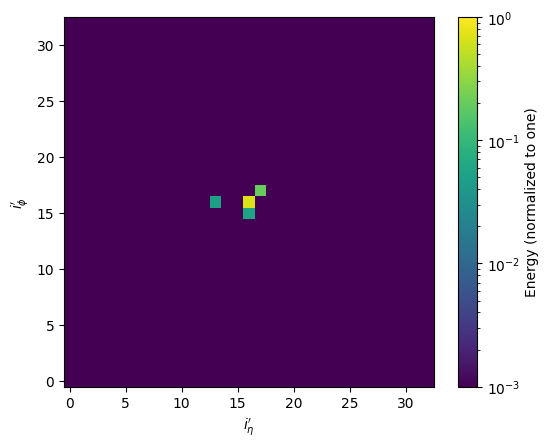

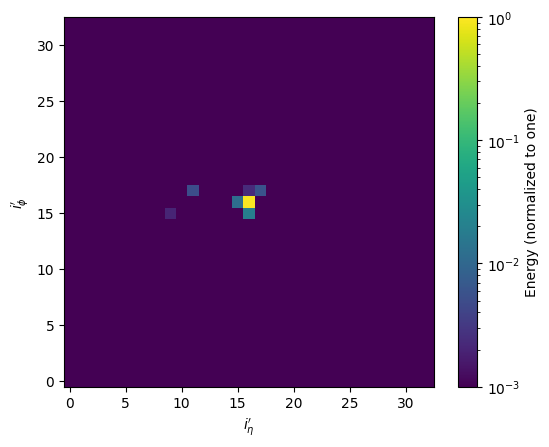

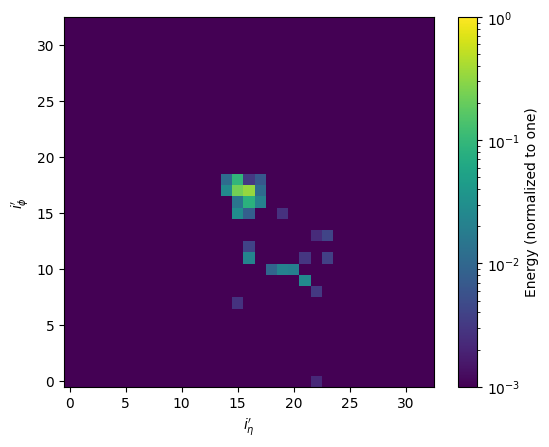

In [11]:
for i in range(3):
    plot_jet(background[i, 0])

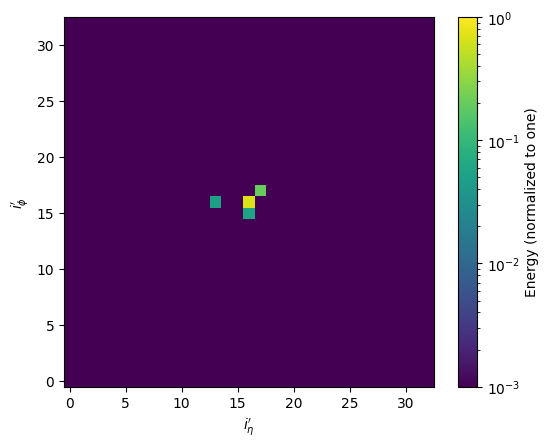

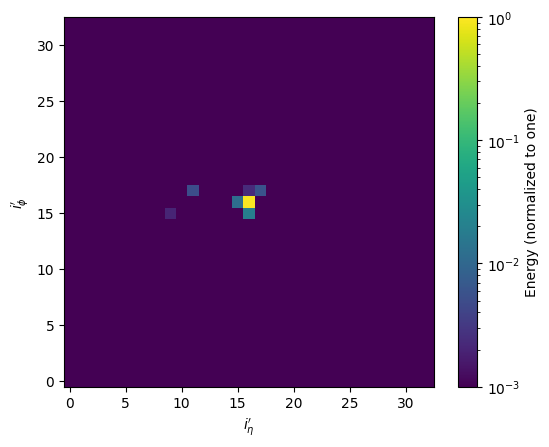

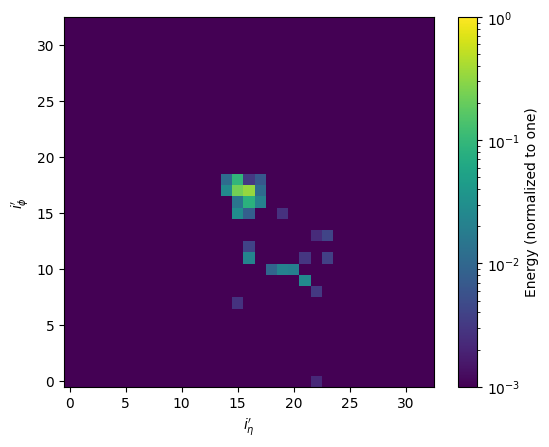

In [12]:
for i in range(3):
    plot_jet(signal[i, 0])

---

**Model**

Our autoencoder is defined below. The architecture is heavily inspired from [2203.01343](https://arxiv.org/abs/2203.01343).


In [13]:
def make_model(latent_space_dims=2, npix=33):
    sample_factor = 3

    # The first half of the network maps the input images to the low-dimensional latent space.
    # The dimension is reduced in steps until we reach the latent space.
    encoder = nn.Sequential(
        # Input has 33*33 dimensions
        nn.Conv2d(1, 5, kernel_size=3, padding=1),
        # 33*33*5 dimensions
        nn.ELU(),
        nn.Conv2d(5, 5, kernel_size=3, padding=1),
        nn.ELU(),
        nn.MaxPool2d(sample_factor),

        # 11*11*5 dimensions

        nn.Conv2d(5, 5, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv2d(5, 5, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv2d(5, 1, kernel_size=3, padding=1),
        nn.ELU(),

        # 11*11 dimensions

        nn.Flatten(),
        nn.Linear((npix // sample_factor)**2, 100),
        # 100 dimensions
        nn.ReLU(),
        nn.Linear(100, latent_space_dims),
        nn.ReLU())

    # The second half of the network maps the low-dimensional latent space to the original
    # images. Notice how it mirrors the encoder architecture: this is a common choice in practice,
    # though for no specific reason.
    # How many dimensions does the data have after each step?
    decoder = nn.Sequential(
        nn.Linear(latent_space_dims, 100),
        nn.ReLU(),
        nn.Linear(100, (npix // sample_factor)**2),
        nn.ReLU(),

        nn.Unflatten(1, (1, (npix // sample_factor), (npix // sample_factor))),

        nn.Conv2d(1, 5, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv2d(5, 5, kernel_size=3, padding=1),
        nn.ELU(),

        nn.Upsample(scale_factor=sample_factor),

        nn.Conv2d(5, 5, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv2d(5, 1, kernel_size=3, padding=1),
        nn.ELU())

    # The autoencoder first encodes the images, then tries to decode them.
    return nn.Sequential(encoder, decoder).to(device), encoder.to(device), decoder.to(device)

In [14]:
autoencoder, _, _ = make_model()

In [15]:
autoencoder.parameters

<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ELU(alpha=1.0)
    (7): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ELU(alpha=1.0)
    (9): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ELU(alpha=1.0)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=121, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=2, bias=True)
    (15): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=121, bias=True)
  

## Training

To train the autoencoder, we use the Mean Square Error loss, $\text{MSE}(\vec x, \vec y)\equiv\langle (\vec x - \vec y)^2 \rangle,$ between the input images and what the network returns. The MSE is 0 if the input and output are equal, and increases when differences are bigger.

In [16]:
def MSE(truth, decoded):
    """
    Computes the element-wise mean square error between true and decoded images.
    """

    # We average over the last three dimensions, representing the channel, x, and y.
    return ((truth - decoded)**2).mean((-1, -2, -3))


def train(autoencoder, data, *, lr=1e-3, epochs=30, batch_size=128):
    """
    Trains an autoencoder using `data`. 
    30 epochs is usually enough for the purpose of this tutorial, 
    although in practice the model takes longer to converge.
    """

    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

    for epoch in range(epochs):
        loss_sum = 0

        for i in range(len(data) // batch_size):
            batch = data[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = MSE(batch, autoencoder(batch)).mean()
            loss.backward()
            optimizer.step()

            loss_sum += loss.detach().cpu().item()

        print(f"Epoch {epoch:2d}: training loss = {loss_sum}")

We start by training on background jets only, using a small subset of the data for speed (the impact on the performance is minimal). Usually, autoencoder training is not sensitive to a small fraction of signal being injected (fear not, we'll check that in a moment).

In [18]:
%%time
train(autoencoder, background[:12800], epochs=3)
#train(autoencoder, background[:25600])


Epoch  0: training loss = 0.03344769691466354
Epoch  1: training loss = 0.030582520324969664
Epoch  2: training loss = 0.029688173031900078
CPU times: total: 4min 34s
Wall time: 1min 9s


How well does our model perform? We can start by taking a look at the reconstruction quality:

In [19]:
@torch.no_grad()
def plot_jet_reconstruction(autoencoder, jet):
    """
    Plots a jet image and its reconstruction by an autoencoder, and show both.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    
    norm = colors.LogNorm(1e-3, 1, clip='True')

    plt.sca(ax1)
    plt.imshow(jet[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("Original")
    plt.ylabel(r"$i_\phi'$")
    plt.xlabel(r"$i_\eta'$")

    plt.sca(ax2)
    plt.imshow(autoencoder(jet)[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("AE Output")
    plt.xlabel(r"$i_\eta'$")

    plt.sca(ax3)
    plt.imshow((jet - autoencoder(jet)).abs()[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("Absolute Difference")
    plt.xlabel(r"$i_\eta'$")

    plt.show()

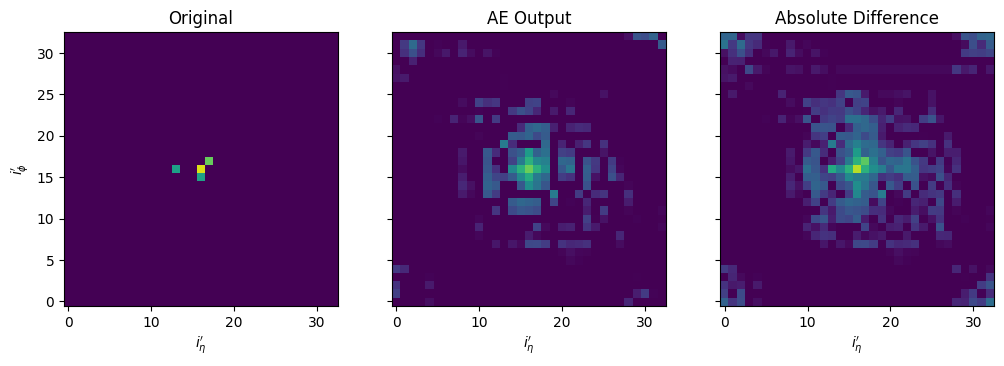

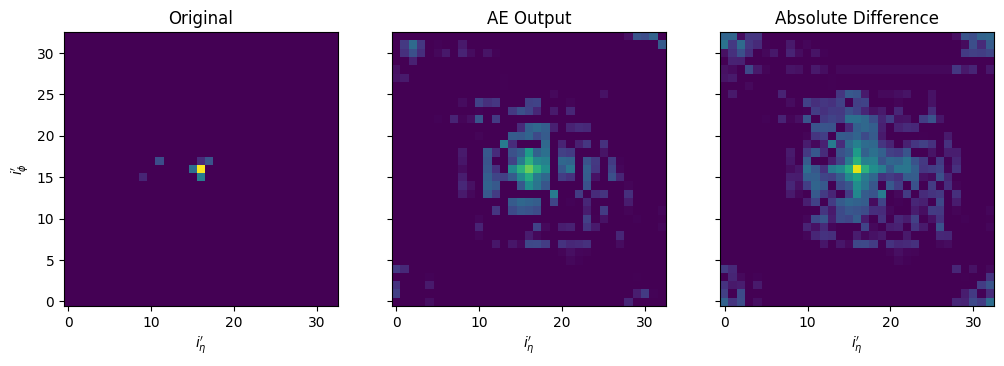

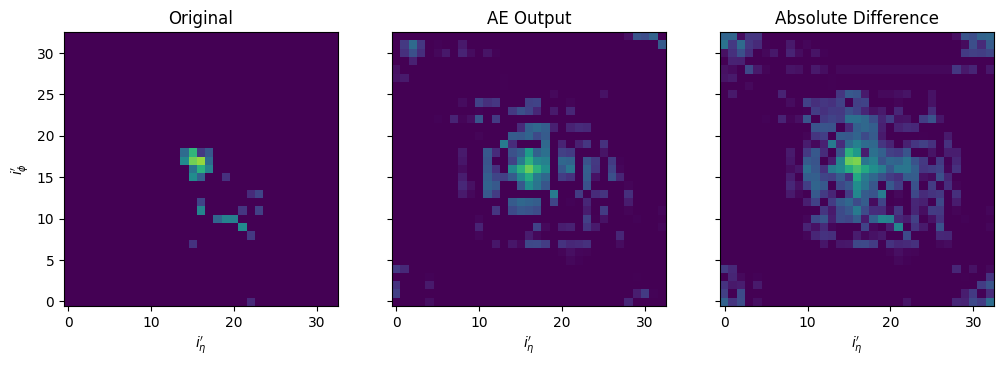

In [20]:
for i in range(3):
    plot_jet_reconstruction(autoencoder, background[i:i + 1, 0:1])

Pretty terrible, isn't it? Well here comes your first task:



<div class="alert alert-block alert-success">
    <h2>Exercise 1</h2>
    Modify the autoencoder architecture to improve reconstruction quality.
</div>    



In [24]:
# used too little epochs and latent dimensions
autoencoder, _, _ = make_model(latent_space_dims=16)
train(autoencoder, background[:12800], epochs=10)

Epoch  0: training loss = 0.17270146709051915
Epoch  1: training loss = 0.04416157104424201
Epoch  2: training loss = 0.03845184241072275
Epoch  3: training loss = 0.035404412366915494
Epoch  4: training loss = 0.03274916470400058
Epoch  5: training loss = 0.031209012580802664
Epoch  6: training loss = 0.029916345898527652
Epoch  7: training loss = 0.028588816174305975
Epoch  8: training loss = 0.02729453082429245
Epoch  9: training loss = 0.0261075210000854


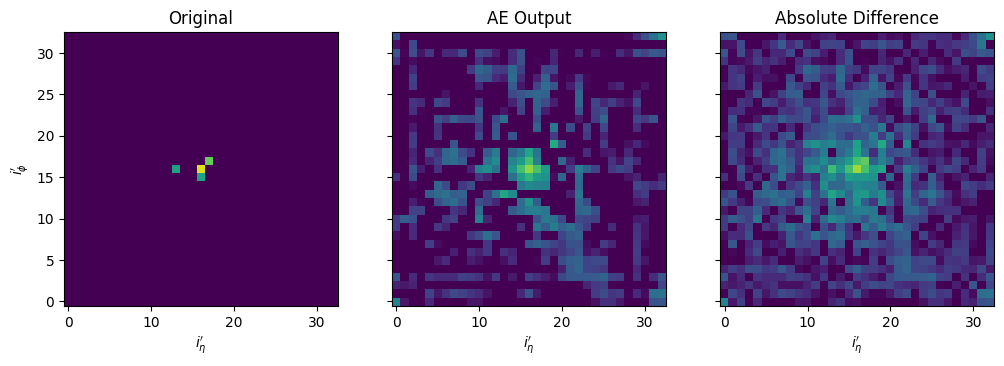

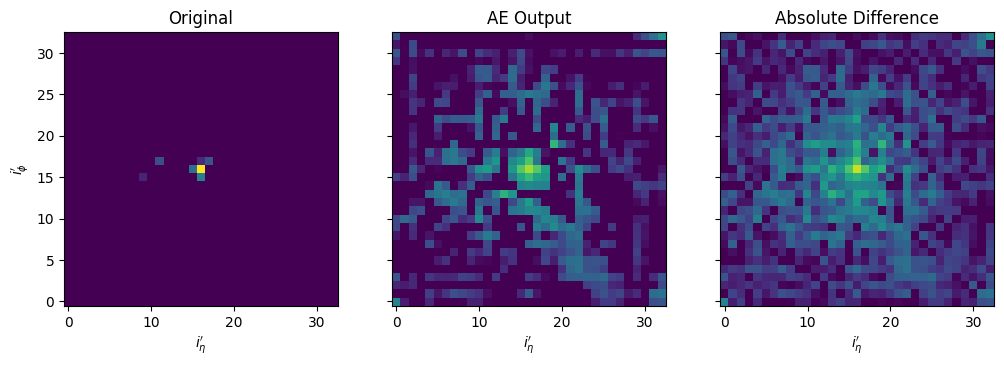

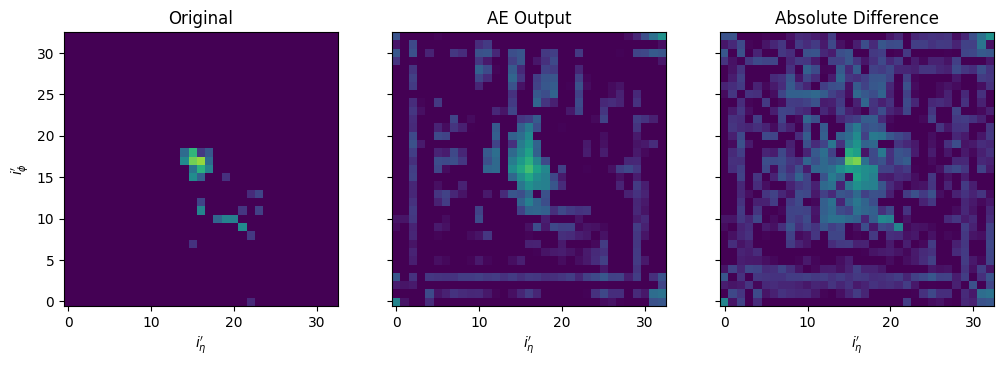

In [25]:
for i in range(3):
    plot_jet_reconstruction(autoencoder, background[i:i + 1, 0:1])

## Anomaly Detection

Once you are confident that the autoencoder can encode (and decode) background images, you can check the same on signal. You will likely find that the autoencoder is confused by the signal inputs and does a bad job reconstructing them.

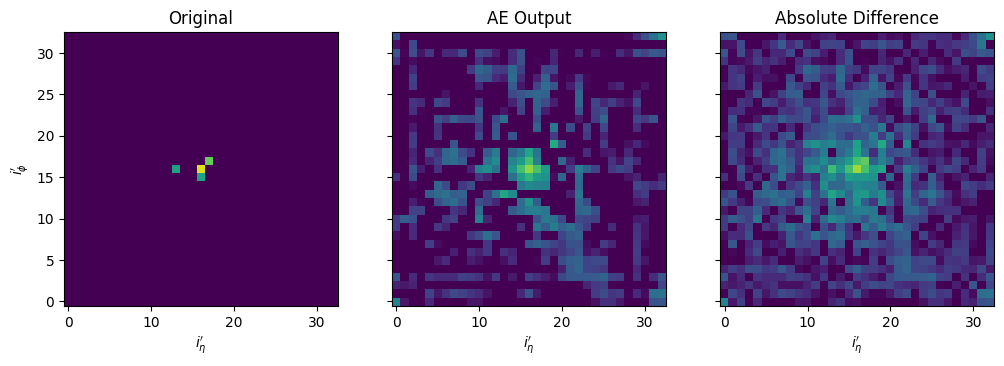

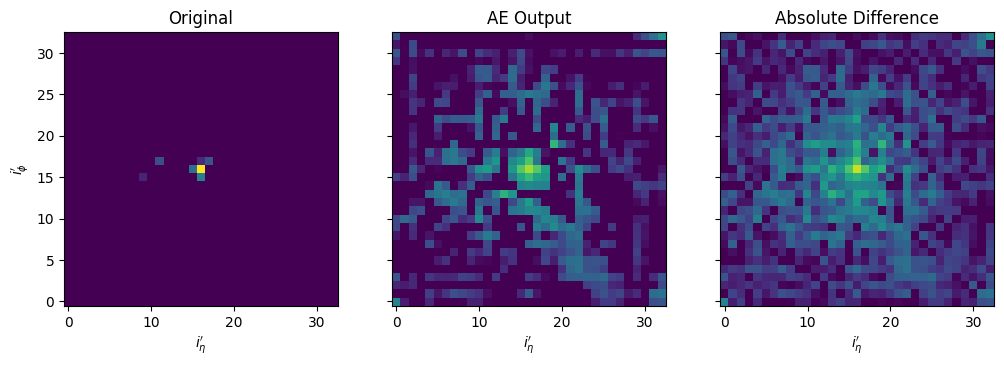

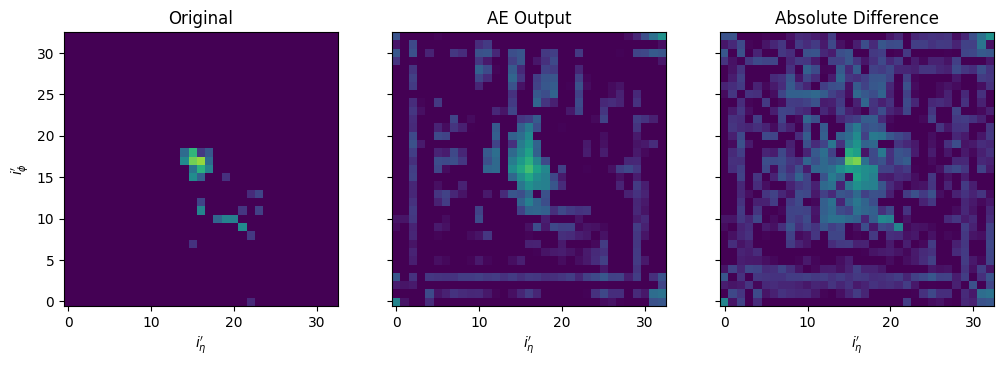

In [26]:
for i in range(3):
    plot_jet_reconstruction(autoencoder, signal[i:i + 1, 0:1])

This feature can be exploited to create an anomaly detection metric: we flag well-reconstructed events as "background" and badly reconstructed ones as "signal". We also use the MSE for this task:

In [27]:
@torch.no_grad()
def autoencoder_roc(autoencoder, signal, background):
    """
    Wrapper around sklearn.metric.roc_curve to compute performance metrics of an autoencoder.
    """

    # Cap background size to avoid running out of CUDA memory. Take it from the end to reduce overlap
    # with the training set.
    background = background[:-2 * len(signal)]

    signal_score = MSE(signal, autoencoder(signal)).cpu()
    background_score = MSE(background, autoencoder(background)).cpu()

    ones = torch.ones(len(signal))
    zeros = torch.zeros(len(background))

    return roc_curve(torch.concat((ones, zeros)), torch.concat((signal_score, background_score)))


def plot_performance(autoencoder, signal, background):
    """
    Plots autoencoder anomaly detection performance metrics.
    """

    fpr, tpr, thr = autoencoder_roc(autoencoder, signal, background)

    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(tpr, 1/fpr, label="Autoencoder")
    ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
    ax[0].set_xlabel("Signal Efficiency (True Postive Rate)")
    ax[0].set_ylabel("Background Rejection (1 / False Positive Rate)")
    ax[0].set_yscale("log")
    ax[0].set_ylim(1,1e3)
    ax[0].grid()
    

    ax[1].plot(tpr, tpr/(fpr**0.5), label="Autoencoder")
    ax[1].plot(tpr, tpr**0.5, linestyle=":", color="black", label="random")
    ax[1].set_xlabel("Signal Efficiency (True Postive Rate)")
    ax[1].set_ylabel("Significance Improvement")
    ax[1].legend(loc="upper right")
    
    plt.show()

In [31]:
# We use the full signal and background so the plot is not limited by statistics.
# The training set is tiny compared to the rest so we do not exclude it (in a real application we would).
plot_performance(autoencoder, signal, background)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5523887160 bytes.

# Extra: Using signal during training

The way we trained our autoencoder was unrealistic: in practice, there would be some signal in the training data. Autoencoders are claimed to be fairly robust to signal contamination of the training set. Let's check this.

**Task 2.** What fraction of signal can the autoencoder accomodate during training?

In [ ]:
def mix(size, background, signal, signal_fraction):
    """
    Mixes signal and background into a tensor of the specified size, such that fraction of signal events is as specified.
    """

    num_signal = int(size * signal_fraction)
    num_background = size - num_signal
    data = torch.concat((background[:num_background], signal[:num_signal]))
    truth = torch.concat((torch.zeros_like(background[:num_background]), torch.ones_like(signal[:num_signal])))
    perm = torch.randperm(len(data))
    return data[perm], truth[perm]

In [ ]:
mixed_data, _ = mix(12800, background, signal, 0.0)
mixed_autoencoder, _, _ = make_model()
train(mixed_autoencoder, mixed_data, epochs=30)
plot_performance(mixed_autoencoder, signal, background)